In [30]:
datasets = ['CUB', 'Derm7pt', 'RIVAL10']
use_dataset = datasets[1]

In [31]:
import os
import sys
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from src.config import PROJECT_ROOT, CUB_CONFIG, DERM7PT_CONFIG, RIVAL10_CONFIG  # noqa: E402
import numpy as np  # noqa: E402

In [32]:
if use_dataset == 'CUB':
    config_dict = CUB_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'CUB')
elif use_dataset == 'Derm7pt':
    config_dict = DERM7PT_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'Derm7pt')
else:
    config_dict = RIVAL10_CONFIG
    DATASET_PATH =  os.path.join(PROJECT_ROOT, 'output', 'RIVAL10')

In [33]:
num_concepts = config_dict['N_TRIMMED_CONCEPTS']
num_classes = config_dict['N_CLASSES']

# Load and Transform Data

In [34]:
C_hat_train = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_train.npy'))
one_hot_Y_train = np.load(os.path.join(DATASET_PATH, 'Y_train.npy'))

C_hat_test = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_test.npy'))
one_hot_Y_test = np.load(os.path.join(DATASET_PATH, 'Y_test.npy'))

if use_dataset == 'Derm7pt':
    C_hat_val = np.load(os.path.join(DATASET_PATH, 'C_hat_sigmoid_val.npy'))
    one_hot_Y_val = np.load(os.path.join(DATASET_PATH, 'Y_val.npy'))

    C_hat_train = np.concatenate((C_hat_train, C_hat_val), axis=0)
    one_hot_Y_train = np.concatenate((one_hot_Y_train, one_hot_Y_val), axis=0)

class_level_concepts = np.load(os.path.join(DATASET_PATH, 'class_level_concepts.npy'))

In [35]:
Y_train = np.argmax(one_hot_Y_train, axis=1)
Y_test = np.argmax(one_hot_Y_test, axis=1)

In [36]:
C_train = []
for y in Y_train:
    C_train.append(class_level_concepts[y])

C_train = np.array(C_train)

### Create DataLoaders for Prototypes Model

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Create Dataloaders
random_seed = 42

def get_loaders(C_hat_train, C_hat_test):
    if use_dataset == 'Derm7pt':
        X_train = torch.tensor(C_hat_train, dtype=torch.float32)
        Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)
    else:
        X_train = torch.tensor(C_hat_train, dtype=torch.float32)
        Y_train = torch.tensor(one_hot_Y_train, dtype=torch.float32)

    X_test = torch.tensor(C_hat_test, dtype=torch.float32, device=device)
    Y_test = torch.tensor(one_hot_Y_test, dtype=torch.float32, device=device)

    # DATALOADERS
    batch_size = 64
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # test_dataset = TensorDataset(X_test, Y_test)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, X_test, Y_test

Using device: mps


# Add Noise to Concept Probabilities

In [38]:
def add_noise_to_concepts(c_hat, noise_level, random_seed=42):
    np.random.seed(random_seed)
    c_hat_noisy = c_hat.copy()

    total_values = c_hat.size
    values_to_modify = int(total_values * noise_level)

    # Get flat indices for high and low values
    flat_c_hat = c_hat.flatten()
    high_indices = np.where(flat_c_hat >= 0.5)[0]
    low_indices = np.where(flat_c_hat < 0.5)[0]

    # Randomly select indices to modify
    high_count = min(values_to_modify // 2, len(high_indices))
    low_count = min(values_to_modify - high_count, len(low_indices))

    selected_high = np.random.choice(high_indices, high_count, replace=False)
    selected_low = np.random.choice(low_indices, low_count, replace=False)

    # Apply noise using flat indexing
    flat_noisy = c_hat_noisy.flatten()

    # Push high values down toward 0.5
    # high_values = flat_noisy[selected_high]
    # max_decrease = high_values - 0.5
    # noise = np.random.uniform(0, 1, len(selected_high)) * max_decrease
    # flat_noisy[selected_high] -= noise
    flat_noisy[selected_high] = 0
    # flat_noisy[selected_high] = np.random.uniform(0, 0.5, len(selected_high))

    # Push low values above 0.5
    # low_values = flat_noisy[selected_low]
    # max_increase = 0.5 - low_values
    # noise = np.random.uniform(0, 1, len(selected_low)) * max_increase
    # flat_noisy[selected_low] += noise
    flat_noisy[selected_low] = np.random.uniform(0.5, 1, len(selected_low))

    return flat_noisy.reshape(c_hat.shape)

In [39]:
noise_level = 0.1
C_hat_test_noisy = add_noise_to_concepts(C_hat_test, noise_level)

In [40]:
close_to_half = (np.sum((C_hat_test > 0.4) & (C_hat_test < 0.6)) / C_hat_test.size)
close_to_half_noisy = (np.sum((C_hat_test_noisy > 0.4) & (C_hat_test_noisy < 0.6))/ C_hat_test.size)

print(f"{close_to_half*100}% of the original values are close to 0.5")
print(f"{close_to_half_noisy*100}% of the original values are close to 0.5")

4.970019986675549% of the original values are close to 0.5
5.796135909393738% of the original values are close to 0.5


# Test Phase 2 With Noise

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import pickle
import os

from src.models import PrototypeClassifier
from src.training import train_epoch
from src.utils import vprint

In [42]:
def predict_nearest_concept(instance, reference_concepts, reference_labels):
    distances = np.sqrt(np.sum((reference_concepts - instance)**2, axis=1))
    min_idx = np.argmin(distances)
    return reference_labels[min_idx]

In [43]:
hyperparams = {
    "CUB": [50, 0.01, 0.01, 0.001],
    "Derm7pt": [50, 0.01, 0.01, 0.001],
    "RIVAL10": [50, 0.01, 0.01, 0.001],
}

In [60]:
def save_model(model, model_name, dataset_name):
    # Create directory for saved models if it doesn't exist
    save_dir = os.path.join(PROJECT_ROOT, 'output', 'saved_models', dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(save_dir, f'{model_name}.pkl')

    if model_name == 'prototypes':
        # PyTorch model
        torch.save(model.state_dict(), model_path)
    else:
        # Scikit-learn models
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

    # print(f"Saved {model_name} model to {model_path}")

def load_model(model_name, dataset_name):
    model_path = os.path.join(PROJECT_ROOT, 'output', 'saved_models', dataset_name, f'{model_name}.pkl')

    if not os.path.exists(model_path):
        return None

    if model_name == 'prototypes':
        # Load PyTorch model
        model = PrototypeClassifier(num_concepts, num_classes).to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()  # Set to evaluation mode
        return model
    else:
        # Load scikit-learn model
        with open(model_path, 'rb') as f:
            return pickle.load(f)

In [69]:
def run_prototypes_model(C_hat_train, C_hat_test, force_retrain=False):
    train_loader, X_test, Y_test = get_loaders(C_hat_train, C_hat_test)

    # Try to load existing model if not forcing retrain
    model = None
    if not force_retrain:
        model = load_model('prototypes', use_dataset)

    if model is None:
        # Train a new model
        model = PrototypeClassifier(num_concepts, num_classes).to(device)

        num_epochs = hyperparams[use_dataset][0]

        optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams[use_dataset][1])
        lambda_binary = hyperparams[use_dataset][2]
        lambda_L1 = hyperparams[use_dataset][3]

        # Training loop
        tqdm_loader = tqdm(range(num_epochs), desc="Training Prototypes", leave=False)
        for epoch in tqdm_loader:
            _, train_accuracy = train_epoch(model, train_loader, optimizer, lambda_binary, lambda_L1, device=device)
            tqdm_loader.set_postfix({"Train Acc": f"{train_accuracy:.2f}%"})

        # Save the trained model
        save_model(model, 'prototypes', use_dataset)
    else:
        print("Using pre-trained prototypes model")

    # Evaluation
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        real_labels = Y_test.argmax(dim=1)
        predictions = model.predict(X_test)

    return (predictions == real_labels).sum().item()/len(predictions)

In [70]:
def test_phase_2_algs(C_hat_train, Y_train, C_hat_test, Y_test, C_train, force_retrain=False, verbose=False):
    # Logistic Regression
    lin_model = load_model('logistic_regression', use_dataset) if not force_retrain else None
    if lin_model is None:
        lin_model = LogisticRegression(max_iter=1000)
        lin_model.fit(C_hat_train, Y_train)
        save_model(lin_model, 'logistic_regression', use_dataset)
    else:
        vprint("Using pre-trained logistic regression model", verbose)
    lin_accuracy = lin_model.score(C_hat_test, Y_test)
    vprint(f"Logistic Regression Test accuracy: {lin_accuracy:.5f}", verbose)

    # KNN
    knn_model = load_model('knn', use_dataset) if not force_retrain else None
    if knn_model is None:
        knn_model = KNeighborsClassifier()
        knn_model.fit(C_hat_train, Y_train)
        save_model(knn_model, 'knn', use_dataset)
    else:
        vprint("Using pre-trained KNN model", verbose)
    knn_accuracy = knn_model.score(C_hat_test, Y_test)
    vprint(f"k-NN Test accuracy: {knn_accuracy:.5f}", verbose)

    # Decision Tree
    dt_model = load_model('decision_tree', use_dataset) if not force_retrain else None
    if dt_model is None:
        dt_model = DecisionTreeClassifier()
        dt_model.fit(C_hat_train, Y_train)
        save_model(dt_model, 'decision_tree', use_dataset)
    else:
        vprint("Using pre-trained decision tree model", verbose)
    dt_accuracy = dt_model.score(C_hat_test, Y_test)
    vprint(f"Decision Tree Test accuracy: {dt_accuracy:.5f}", verbose)

    # MLP
    mlp_model = load_model('mlp', use_dataset) if not force_retrain else None
    if mlp_model is None:
        mlp_model = MLPClassifier(hidden_layer_sizes=(512,256, 128), max_iter=1000)
        mlp_model.fit(C_hat_train, Y_train)
        save_model(mlp_model, 'mlp', use_dataset)
    else:
        vprint("Using pre-trained MLP model", verbose)
    mlp_accuracy = mlp_model.score(C_hat_test, Y_test)
    vprint(f"MLP Test accuracy: {mlp_accuracy:.5f}", verbose)

    # DISTANCE TO CLASS-LEVEL CONCEPTS (no training required, just calculation)
    class_accuracy = 0
    if C_train is not None:
        correct_predictions = 0

        for i, test_instance in enumerate(C_hat_test):
            predicted_label = predict_nearest_concept(test_instance, C_train, Y_train)
            true_label = Y_test[i]

            if predicted_label == true_label:
                correct_predictions += 1

        class_accuracy = correct_predictions / len(C_hat_test)
        vprint(f"Overall accuracy using concept-based nearest neighbor: {class_accuracy:.5f}", verbose)

    # PROTOTYPES MODEL
    proto_accuracy = run_prototypes_model(C_hat_train, C_hat_test, force_retrain)
    vprint(f"Prototype Model Test accuracy: {proto_accuracy:.5f}", verbose)

    return {
        "lr": lin_accuracy,
        "knn": knn_accuracy,
        "dt": dt_accuracy,
        "mlp": mlp_accuracy,
        "class": class_accuracy,
        "proto": proto_accuracy,
    }

In [71]:
# First run: Train and save all models
print("First run: Training and saving all models")
test_phase_2_algs(C_hat_train, Y_train, C_hat_test, Y_test, C_train, force_retrain=True, verbose=True)

First run: Training and saving all models
Logistic Regression Test accuracy: 0.66329
k-NN Test accuracy: 0.60000
Decision Tree Test accuracy: 0.57215
MLP Test accuracy: 0.65316
Overall accuracy using concept-based nearest neighbor: 0.64810


Training Prototypes:   0%|          | 0/50 [00:00<?, ?it/s]

Prototype Model Test accuracy: 0.64810


{'lr': 0.6632911392405063,
 'knn': 0.6,
 'dt': 0.5721518987341773,
 'mlp': 0.6531645569620254,
 'class': 0.6481012658227848,
 'proto': 0.6481012658227848}

In [65]:
noise_levels = np.arange(0, 1.1, 0.1)

In [66]:
lr_results = []
knn_results = []
dt_results = []
mlp_results = []
class_results = []
proto_results = []

for nl in noise_levels:
    print(f"Testing noise of {nl*100:.0f}%")
    C_hat_test_noisy = add_noise_to_concepts(C_hat_test, nl)
    results = test_phase_2_algs(C_hat_train, Y_train, C_hat_test_noisy, Y_test, C_train)
    lr_results.append(results["lr"])
    knn_results.append(results["knn"])
    dt_results.append(results["dt"])
    mlp_results.append(results["mlp"])
    class_results.append(results["class"])
    proto_results.append(results["proto"])

Testing noise of 0%
Using pre-trained prototypes model
Testing noise of 10%
Using pre-trained prototypes model
Testing noise of 20%
Using pre-trained prototypes model
Testing noise of 30%
Using pre-trained prototypes model
Testing noise of 40%
Using pre-trained prototypes model
Testing noise of 50%
Using pre-trained prototypes model
Testing noise of 60%
Using pre-trained prototypes model
Testing noise of 70%
Using pre-trained prototypes model
Testing noise of 80%
Using pre-trained prototypes model
Testing noise of 90%
Using pre-trained prototypes model
Testing noise of 100%
Using pre-trained prototypes model


In [ ]:

# Assuming noise_levels, C_hat_test, C_hat_train, Y_train, Y_test, C_train are defined
lr_results = []
knn_results = []
dt_results = []
mlp_results = []
class_results = []
proto_results = []

print("\nRunning robustness testing with different noise levels using saved models")
for nl in noise_levels:
    print(f"Testing noise of {nl*100:.0f}%")
    C_hat_test_noisy = add_noise_to_concepts(C_hat_test, nl)
    results = test_phase_2_algs(C_hat_train, Y_train, C_hat_test_noisy, Y_test, C_train, force_retrain=False)
    lr_results.append(results["lr"])
    knn_results.append(results["knn"])
    dt_results.append(results["dt"])
    mlp_results.append(results["mlp"])
    class_results.append(results["class"])
    proto_results.append(results["proto"])



Running robustness testing with different noise levels using saved models
Testing noise of 0%
Using pre-trained prototypes model
Testing noise of 10%
Using pre-trained prototypes model
Testing noise of 20%
Using pre-trained prototypes model
Testing noise of 30%
Using pre-trained prototypes model
Testing noise of 40%
Using pre-trained prototypes model
Testing noise of 50%
Using pre-trained prototypes model
Testing noise of 60%
Using pre-trained prototypes model
Testing noise of 70%
Using pre-trained prototypes model
Testing noise of 80%
Using pre-trained prototypes model
Testing noise of 90%
Using pre-trained prototypes model
Testing noise of 100%
Using pre-trained prototypes model


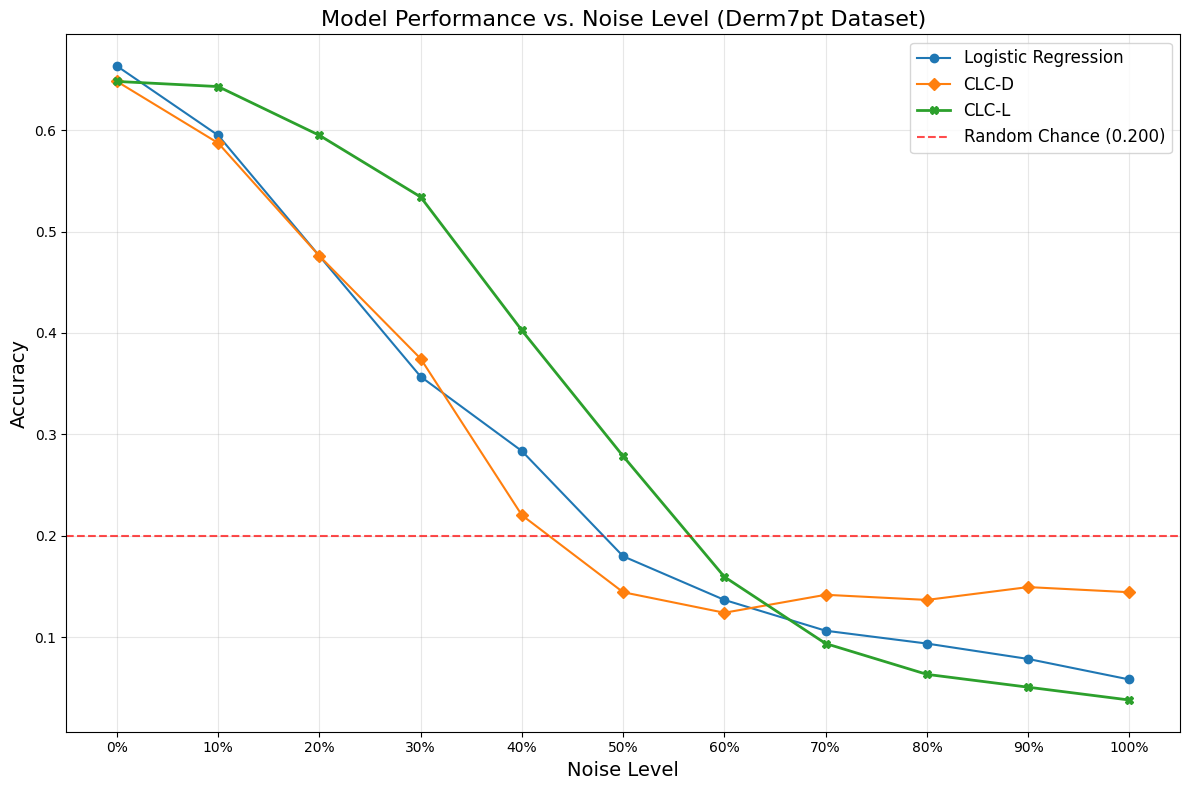

In [68]:
import matplotlib.pyplot as plt

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Plot each algorithm's results
plt.plot(noise_levels, lr_results, marker='o', label='Logistic Regression')
# plt.plot(noise_levels, knn_results, marker='s', label='K-Nearest Neighbors')
# plt.plot(noise_levels, dt_results, marker='^', label='Decision Tree')
# plt.plot(noise_levels, mlp_results, marker='*', label='MLP')
plt.plot(noise_levels, class_results, marker='D', label='CLC-D')
plt.plot(noise_levels, proto_results, marker='X', label='CLC-L', linewidth=2)

plt.grid(True, alpha=0.3)
plt.xlabel('Noise Level', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title(f'Model Performance vs. Noise Level ({use_dataset} Dataset)', fontsize=16)

# Set y-axis limits from 0 to 1
# plt.ylim(0, 0.7)

# Format x-axis ticks as percentages
plt.xticks(noise_levels, [f'{nl*100:.0f}%' for nl in noise_levels])

# Add a horizontal line for random chance accuracy (1/num_classes)
random_chance = 1/num_classes
plt.axhline(y=random_chance, color='r', linestyle='--', alpha=0.7,
            label=f'Random Chance ({random_chance:.3f})')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [52]:
import pandas as pd
import os

# Create a DataFrame with the noise level and results from each algorithm
results_df = pd.DataFrame({
    'Noise_Level': noise_levels,
    'Logistic_Regression': lr_results,
    'KNN': knn_results,
    'Decision_Tree': dt_results,
    'MLP': mlp_results,
    'Concept_Based_NN': class_results,
    'Prototype': proto_results
})

# Format the DataFrame for better readability
results_df['Noise_Level'] = results_df['Noise_Level'].apply(lambda x: f"{x:.1f}")

# Define the output path
output_dir = os.path.join(PROJECT_ROOT, 'output', 'noise_results')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'{use_dataset}_noise_experiment_results.csv')

# Save the results to CSV
results_df.to_csv(output_path, index=False)

print(f"Results saved to: {output_path}")

Results saved to: /Users/pb/Documents/career/lab_ujm/hybrid-cbm-prototype-model/output/noise_results/Derm7pt_noise_experiment_results.csv


In [53]:
proto_results

[0.6481012658227848,
 0.6430379746835443,
 0.5949367088607594,
 0.5341772151898734,
 0.40253164556962023,
 0.27848101265822783,
 0.15949367088607594,
 0.09367088607594937,
 0.06329113924050633,
 0.05063291139240506,
 0.0379746835443038]